In [1]:
%pylab inline
from constant import * 

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vgrid = np.load("Value.npy")

In [3]:
# calculate the stationary distribution 
S_distribution = jnp.ones(nS)/nS
for _ in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)
    
#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

E_distribution = jnp.ones(2)/2
for _ in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [4]:
num = 10000

In [5]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4h 34min 49s, sys: 37min 48s, total: 5h 12min 38s
Wall time: 23min 45s


In [6]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

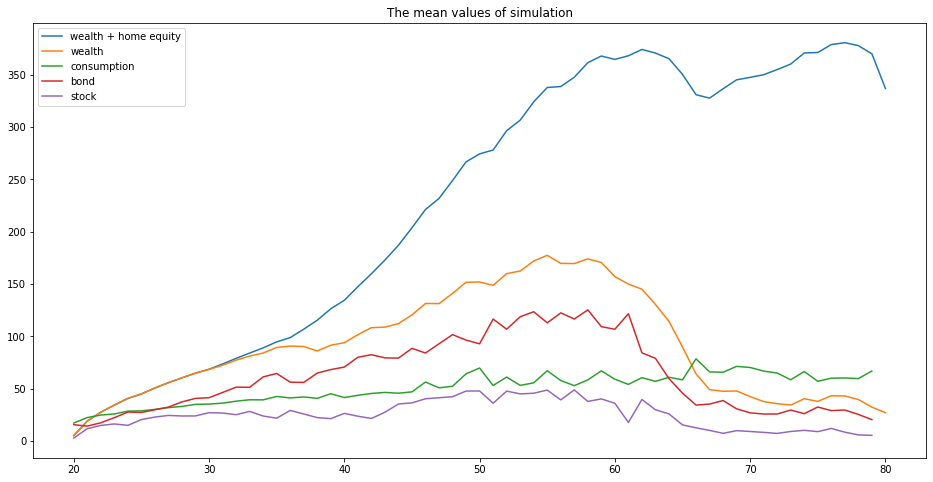

In [8]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

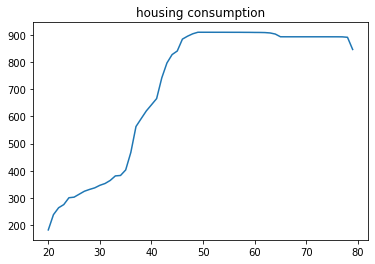

In [10]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")

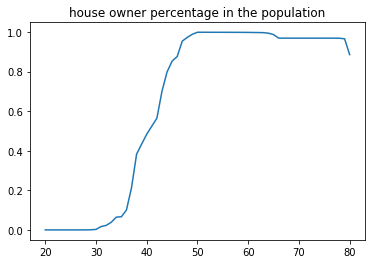

In [12]:
plt.title("house owner percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")

In [109]:
cuts = jnp.percentile((ws + H*pt*os - ms)[44,:], [0, 0.33, 0.66, 1])

0
1
2


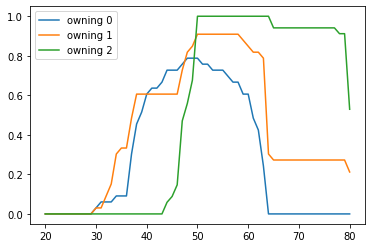

In [110]:
for i in range(len(cuts) - 1):
    print(i)
    lower = cuts[i]
    higher = cuts[i+1]
    indeces = jnp.where(((ws + H*pt*os - ms)[44,:] >= cuts[i]) * ((ws + H*pt*os - ms)[44,:] < cuts[i+1]))
    plt.plot(range(20, T_max + 21),(os[:, indeces[0]]).mean(axis = 1), label = "owning " + str(i))
plt.legend()

In [86]:
(ws + H*pt*os - ms)[44,:].max()

DeviceArray(787.97974, dtype=float32)

In [49]:
jnp.where((ws + H*pt*os - ms)[44,:] == (ws + H*pt*os - ms)[44,:].min())

(DeviceArray([2592], dtype=int32),)

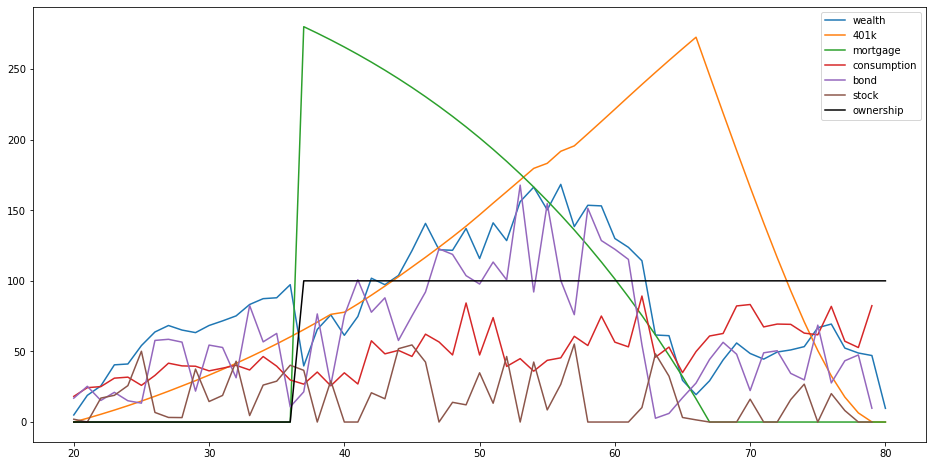

In [137]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 36
plt.figure(figsize = [16,8])
plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
plt.legend()

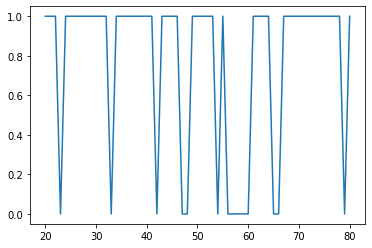

In [53]:
plt.plot(range(20, T_max + 21),es[:,agentNum], label = "employment")

In [65]:
(ks/(bs+ks))[:,9018].mean()

DeviceArray(0.29903075, dtype=float32)

In [66]:
(ks/(bs+ks))[:,agentNum].mean()

DeviceArray(0.3296887, dtype=float32)

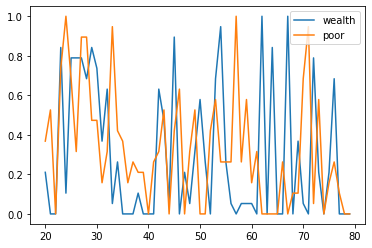

In [64]:
plt.plot(range(20, T_max + 20),(ks/(bs+ks))[:,9018], label = "wealth")
plt.plot(range(20, T_max + 20),(ks/(bs+ks))[:,agentNum], label = "poor")
plt.legend()

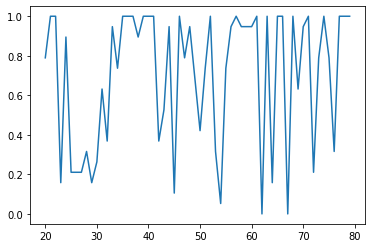

In [47]:
plt.plot(range(20, T_max + 20),(bs/(bs+ks))[:,agentNum], label = "bond")